
# &emsp;&emsp;&emsp;&emsp;Wheat Detection Using Pytorch and AWS

## Overview:

In this project, an object detection model using PyTorch transfer learning model will be used to detect wheeat heads. 
Thee dataset used is part of past Kaggle competition that ran by University of Saskatchewan, with corporation with other universities: https://www.kaggle.com/c/global-wheat-detection 


The automated process of detecting wheat in images helps in efficient crop decisions and help in reducing resources. A state of the art machine learning model can replace manual crop detection by workers, saving valuable time and effort.

**The dataset** consists of:
1. training set - 3422 jpg images
2. testing set - 10 jpg images
3. train.csv - a csv with known boundary boxes (targets) for the training set.
    columns: **[image_id, image width, image height, boundary boxes, source]**
    boundary boxes column contain 4 elements: **[x coordinate of box, y coordinate of box, box width, box height]**

**In this Project** I will use Fast-RCNN-FPN (https://arxiv.org/abs/1506.01497) pretrained model. under source/ folder you will find two files:
1. train.py - training script that contains all pre-processing of the data + training job
2. predict.py - a prediction script according to AWS requirements.

I will explain in greater detail each file as we dive deeper into the project. 

**Deployment** will also be perfromed using SageMaker tools after a training model is ready.  

## The problem at hand:

Can Fast-RCNN-FPN model detect all or most wheat heads in an image ? can this process be automated using this model ? 
In order to answer these questions we must define some metrics to evaluate the performance of the model

The expected prediction should produce a list of boundary boxes for a single image and their corresponding scores.

In this project a threshold score of 0.5 is chosen as minimum score that boundary box can have. any value lower than 0.5 will not be recorded in prediction stage. 

## Metric of performance:

Intersection over Union (IoU) is defined as the area of the intersection divided by the area of the union of a predicted bounding box and a ground-truth box. 

In layman’s terms, this is the process:

for each detection that has a confidence score > threshold:

  &emsp;among the ground-truths, choose one that belongs to the same class and has the highest IoU with the detection
  
  &emsp;if no ground-truth can be chosen or IoU < threshold (e.g., 0.5): <br>
     &emsp;&emsp; the detection is a false positive <br>
  &emsp;else: <br>
    &emsp;&emsp; the detection is a true positive <br>


## Workflow:

#### 1. Importing necessary packages
#### 2. Load and Pre-Process
#### 3. Splitting Data
#### 4. Visualizing an image with labels
#### 5. Setting up a model
#### 6. Training Job using SageMaker
#### 7. Deploying the model
#### 8. making Predictions 
#### 9. Further steps 
#### 10. Evaluation on Kaggle

## 1. Importing necessary packages

In [5]:
#general
import numpy as np
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt
import pickle
import json
import cv2

#PyTorch
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset
from torchvision import transforms

In [6]:
# aws config
import boto3
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, Session
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

DATA_PATH = 'data'
TRAIN_PATH = 'data/train'

session = Session()

role = get_execution_role()

bucket = session.default_bucket()

prefix = 'wheat-data'

input_data = 's3://sagemaker-us-east-1-267252719644/wheat-data'

output_path = f"s3://{bucket}/{prefix}"
print(bucket)

sagemaker-us-east-1-267252719644


## 2. Load and Pre-Process
Before loading the csv file, I will store the names of images in a txt file. 
This will be useful when creating train.py for training / validating.
 <br>
I will store the names of images and clean the dataframe according to existing images:

In [4]:
images_names = os.listdir('data/train')

with open("data/images_names.txt", "w") as fp:   #json
    json.dump(images_names, fp)

with open("data/images_names.txt", "r") as fp:   # un-json it
    b = json.load(fp)
b[:10]

['1fe63a46a.jpg',
 '92b234199.jpg',
 'cfc9040ca.jpg',
 '03a988adf.jpg',
 '557d15524.jpg',
 'd0ca0d7a0.jpg',
 'd1ea44cc7.jpg',
 '03ad2a35c.jpg',
 'c15a563d8.jpg',
 'c78edc091.jpg']

In [5]:
# need to do it again for test images, so I will create a function for future use:

def get_images_names(train_or_test = "train"):
    if train_or_test == "train":
        images_names = os.listdir('data/train')
        with open("data/images_names.txt", "w") as fp:   #json
            json.dump(images_names, fp)
        return
    
    images_names = os.listdir('data/test')
    with open("data/images_names_test.txt", "w") as fp:   #json
        json.dump(images_names, fp)
    return 
        
get_images_names("train")

In [6]:
# reading the csv file containing labels 
df = pd.read_csv(f"{DATA_PATH}/train.csv")

In [7]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


The dataframe above has one column named 'bbox'. each entry has 4 values: **[x coordinate, y coordinate, box width, box height]** <br>
for convenience, I will break that column into 4 separate columns

In [11]:
# split bbox column into [x,y,w,h] columns:
# df[['x','y','w','h']] = np.nan or:
df['x'] = np.zeros(df.shape[0])
df['y'] = np.zeros(df.shape[0])
df['w'] = np.zeros(df.shape[0])
df['h'] = np.zeros(df.shape[0])

df[['x','y','w','h']] = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=','))).astype(np.float)
df.drop(columns=['bbox'], inplace=True)

In [12]:
df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [14]:
images_names = os.listdir(TRAIN_PATH)

## 3. Splitting Data
I will first make the first column image_id as my index:

In [15]:
file_image_ids = []
for name in images_names:
    image_id = name.split('.jpg')[0]
    file_image_ids.append(image_id)
file_image_ids[:10]

['1fe63a46a',
 '92b234199',
 'cfc9040ca',
 '03a988adf',
 '557d15524',
 'd0ca0d7a0',
 'd1ea44cc7',
 '03ad2a35c',
 'c15a563d8',
 'c78edc091']

In [16]:
df.index = df['image_id']

In addition, I am not using the whole dataset, so no need in some entries in the dataframe:

In [17]:
demo_data = df[df['image_id'].isin(file_image_ids)]
demo_data.head()

,image_id,width,height,source,x,y,w,h
image_id,,,,,,,,
91c9d9c38,91c9d9c38,1024,1024,usask_1,124.0,273.0,59.0,73.0
91c9d9c38,91c9d9c38,1024,1024,usask_1,688.0,939.0,61.0,85.0
91c9d9c38,91c9d9c38,1024,1024,usask_1,639.0,674.0,83.0,41.0
91c9d9c38,91c9d9c38,1024,1024,usask_1,562.0,410.0,96.0,83.0
91c9d9c38,91c9d9c38,1024,1024,usask_1,665.0,92.0,96.0,78.0


Splitting the data:

In [23]:
# split data into validation / train sets:
image_ids = demo_data['image_id'].unique()

# 90% will go for training
split_len = round(len(image_ids)*0.9)

train_ids = image_ids[:split_len]
valid_ids = image_ids[split_len:]

train = demo_data[demo_data['image_id'].isin(train_ids)]
valid = demo_data[demo_data['image_id'].isin(valid_ids)]

print(f"size of train set: {train['image_id'].unique().shape}\nsize of validation set:{valid['image_id'].unique().shape}")

size of train set: (994,)
size of validation set:(111,)


## 4. Visualizing an image with labels

In [16]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
        ax.set_title(titles[i])
    return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])

    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = plt.Rectangle(
        xy=(bbox[0], bbox[1]),
        width=bbox[2] - bbox[0],
        height=bbox[3] - bbox[1],
        fill=False,
        edgecolor=color,
        linewidth=2)
        axes.add_patch(rect)
    if labels and len(labels) > i:
        text_color = 'k' if color == 'w' else 'w'
        axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

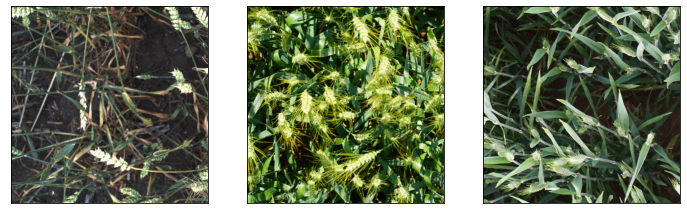

In [17]:
num_rows, num_cols = 1, 3
imgs = [plt.imread(f'{TRAIN_PATH}/{n}.jpg') for n in demo_data['image_id'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()

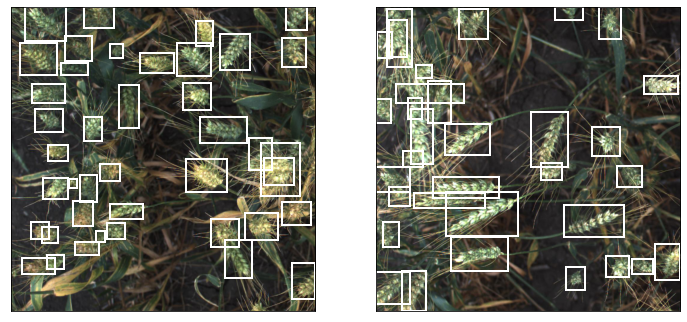

In [16]:
num_rows, num_cols = 1, 2
ids = demo_data['image_id'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{TRAIN_PATH}/{n}.jpg') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=6)
for ax, id in zip(axes, ids):
    
    datas = demo_data[demo_data['image_id'] == id]
    bboxes = [(d['x'], d['y'], d['x']+d['w'], d['y']+d['h']) for _, d in datas.iterrows()]
    show_bboxes(ax, bboxes, labels=None, colors=['g'])
plt.show()

## 5. Setting up a model

The pretrained model was trained on COCO dataset, a very large dataset containing thousands of images. <br>
I will have to adjust the output layers since I only work with 2 classes: background + wheat objects 

In [101]:
def set_model(num_classes:int):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    input_features = model.roi_heads.box_predictor.cls_score.in_features
    # changing the last layer according to the dataset:
    model.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)
    return model

In [102]:
# transfer learning pretrained model:
num_classes = 2
model = set_model(num_classes)

In [48]:
# making sure output layers changed:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)

## 6. Training Job using SageMaker

Now, here comes the fun part: training the model. <br>
I have created a new script file train.py. It contains all necessary functions to train the model. Lets take a look:


Inside this script you will see those functions:
1. **"main"** function - all of the pre-processing steps above are in main. I wanted to make it as easy as possible to get a training model.
    the names of the images we stored before is used to create a clean dataframe. 
    Then we call train_model()
2. **train_model** - creating a train/validation loader using Wheat Class (see below), and training in batches. 
3. **Wheat Class** - this class will return an image, target, and image index given some index. for example, train_dataset[index] will return a tensor with 3 objects: [image, target, image index]
4. **set_model** - same code we used for setting up the model above.

After training is over, the model is saved on the cloud, along with the losses from each epoch from training/validation batches.


In [10]:
!pygmentize source/train.py

import argparse
import sys
import os
import json
import pandas as pd
import numpy as np
from PIL import Image
from smart_open import open
import pickle
import time
import boto3

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset
from torchvision import transforms

# GLOBALS
# bucket name : sagemaker-us-east-1-267252719644 
CSV_FILE_PATH = 'S3://sagemaker-us-east-1-267252719644/wheat-data/train.csv'
DATA_FOLDER_PATH = 's3://sagemaker-us-east-1-267252719644/wheat-data/train/'
IMG_NAME_PATH = 'S3://sagemaker-us-east-1-267252719644/wheat-data/images_names.txt'


class Wheat(Dataset):

    def __init__(self, dataframe, image_dir, transforms=False):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir


### **Before I move on, now will be a good time to upload all files to the bucket:**

In [3]:
# upload data to bucket
input_data = session.upload_data(path=DATA_PATH, bucket=bucket, key_prefix=prefix)

# I also want to check the torch version Im using in this kernel, hopefully its 1.6 or above
# I will have some issues loading the model / features from the kernel using torch.load,
# but I will upload it manually when the time comes. 

torch.__version__

'1.4.0'

In [3]:
from sagemaker.pytorch import PyTorch
local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.p2.xlarge"

est = PyTorch(
    entry_point="train.py",
    source_dir="source",  # directory of my training script
    role=role,
    framework_version="1.7",
    py_version="py3",
    instance_type=instance_type,
    instance_count=1,
    output_path=output_path,
    hyperparameters={"batch_size": 8, "epochs": 8, "lr": 0.01}, # I wanted batch size = 16,
                                                                # but encoutered memory allocation issues
)

In [ ]:
# training model

channel = {'train': input_data}
est.fit(channel)

2021-05-21 18:20:30 Starting - Starting the training job...
2021-05-21 18:20:54 Starting - Launching requested ML instancesProfilerReport-1621621230: InProgress
......
2021-05-21 18:21:54 Starting - Preparing the instances for training............
2021-05-21 18:23:54 Downloading - Downloading input data...
2021-05-21 18:24:25 Training - Downloading the training image.....................
2021-05-21 18:27:55 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-05-21 18:27:51,877 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-05-21 18:27:51,904 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-05-21 18:27:51,913 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-05-21 18:27:52,399 sagemaker-training-toolkit INFO     Invoking user script


#### The ipython notebook disconnected after 30 minutes. This happens every 30-60 minutes. Very annoying!
#### But the training job is still working in the background ! I followed it in logs and it completed all 8 epochs in 2 hours.
#### note to Udacity: I have no idea why the kernel throws me out every hour.. its very frustrating. 

In [7]:
# save model artifact:

pt_model_data = est.model_data
print("Model artifact saved at:\n", pt_model_data)

# %store pt_model_data

Model artifact saved at:
 s3://sagemaker-us-east-1-267252719644/wheat-data/pytorch-training-2021-05-21-18-20-30-424/output/model.tar.gz


Now that I have the model artifact, I can use it to deploy the model and make predictions! 

## 7. Deploying the model

I will use ml.p2.xlarge to deploy the model, and created a new script file named predict.py, see code below <br>

At the bottom of the script, I have also included some extra information on the model I am using and how it makes predictions. 
It returns different results depending if one is in .train() mode, or eval() mode. (It took me some time to figure this out...)

def 
def 
def 
def 
predict.py must have **4** main functions in it: 
1. **model_fn(model_dir)** - This is where I upload the saved model. return value can now be used in prediction_fn
2. **input_fn(request_body, content_type)** - input_fn takes the returned value from kernel and puts in in variable:request_body <br>
   the content type is defined as image/jpeg, but sagemaker will require me to change this into byte-array type as input. 
   I will then deseriliaze it inside input_fn, i.e converting it back to an RGB image.
   input_fn returns a preprocessed transformed image.
3. **predict_fn(input_data, model)** - input_data parameter is the returned value from input_fn, i.e the transformed image. 
    It is also using the model that was returned in model_fn. The function then returns a prediction: List[Dict[Tensor]] of boxes, labels,       scores.
4. **output_fn(prediction, content_type)** - finally, the returned prediction is stored in prediction parameter, and once content type is verified, the serialization to json files takes place, and we get a json file containing: boundary boxes, corresponding scores

In [12]:
!pygmentize source/predict.py

import os
import json
import pandas as pd
import numpy as np
from PIL import Image
import logging
# import boto3 
# I wanted to retreive one image from the bucket for inference. but reading the docs I see there are restrictions in doing that.
# so I tried to use boto3 and it didnt even read the script. (ModelError then runtime error)
# so I will shut down the deserializer, and create my own. predictor.predict(input) will get <byte class> and 
# a custom deserializer in input_fn() will convert it: <byte class> --> image with shape [3, 1024, 1024]
import io

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

logger = logging.getLogger(__name__)

def model_fn(model_dir):
    print("model loading ")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
    input_features

In [3]:
# load model artifact:

pt_model_data = 's3://sagemaker-us-east-1-267252719644/wheat-data/pytorch-training-2021-05-21-18-20-30-424/output/model.tar.gz'

In [4]:
# Deployment: 
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# those serializers actually make my life more complicated.. does not give you any flexibility ! 
# might as well define my own deserializer/serializers inside input_fn/output_fn 

local_mode = False
if local_mode:
    instance_type = "local"
else:
    instance_type = 'ml.p2.xlarge'
    
model = PyTorchModel(
    entry_point="predict.py",
    source_dir="source",
    role=role,
    model_data=pt_model_data, # saved model in bucket 
    framework_version="1.7",
    py_version="py3"
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=None,
    deserializer=None)

#predictor.update_endpoint()

------------------------!

In [5]:
predictor.endpoint_name # will use it to invoke the endpt later. 

'pytorch-inference-2021-05-24-04-59-44-970'

As mentioned above, the input data MUST be sent as a byte array or any other type accepted by the service! 
see code below:

In [17]:
# preparing the data to be sent to predict.py according to aws requirements:

import io
# get 1 test image from s3 bucket or locally: 

# can use .get_object() to pick an image or just pick one image locally: 
url = 's3://sagemaker-us-east-1-267252719644/wheat-data/test/2fd875eaa.jpg'
bucket = url.split('/')[2]
key = url.split('/')[3:]
key =  "/".join(key)
s3 = boto3.client('s3')

file_like_obj = io.BytesIO(s3.get_object(Bucket=bucket, Key=key)['Body'].read())
test_image = Image.open(file_like_obj).convert("RGB")

# get the correct ContentType format that invoke_endpoint accepts. 
# more about it: https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_runtime_InvokeEndpoint.html
img_byte_arr = io.BytesIO()
test_image.save(img_byte_arr, format='JPEG')
img_byte_arr = img_byte_arr.getvalue()

## 8. making Predictions

Now that our image is the correct format, we can finally get the bboxes and plot it with the image:
I will use invoke_endpoint. this function can also be used inside a lambda function (see last section in this notebook where I create this function)

In [18]:
# invoke endpt to make predictions on 1 image: 
runtime = boto3.Session().client('sagemaker-runtime')
response = runtime.invoke_endpoint(EndpointName = predictor.endpoint_name,
                                    ContentType = 'image/jpeg',
                                    Body=img_byte_arr)

In [19]:
# get boxes and scores from response above
from ast import literal_eval

# 'a' below holds both bboxes and scores
a = response['Body'].read()
the_bbxes = literal_eval(a.decode('utf-8'))[0][0]
the_scores = literal_eval(a.decode('utf-8'))[0][1]

In [20]:
the_bbxes

[[463, 492, 536, 627],
 [108, 585, 241, 663],
 [735, 887, 826, 972],
 [393, 794, 467, 880],
 [467, 353, 580, 446],
 [232, 0, 322, 56],
 [734, 148, 814, 238],
 [945, 650, 1021, 742],
 [536, 868, 639, 978],
 [0, 735, 87, 840],
 [97, 0, 217, 48],
 [1, 910, 98, 990],
 [907, 880, 979, 971],
 [126, 844, 204, 912],
 [2, 2, 90, 72],
 [429, 63, 526, 137],
 [989, 580, 1023, 669],
 [934, 775, 1016, 856],
 [119, 36, 211, 106],
 [887, 48, 983, 135]]

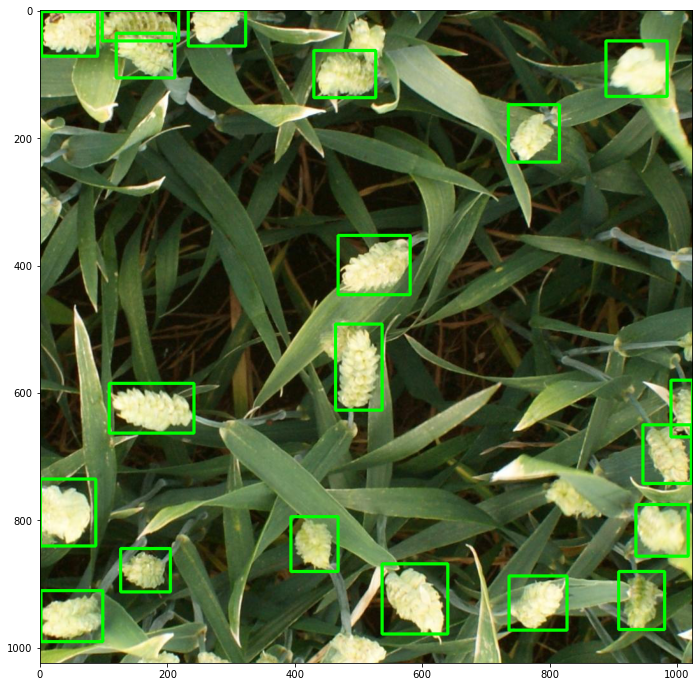

In [3]:
# RUN this after I get my response results 

fig, ax = plt.subplots(1, 1, figsize=(18, 12))
im = Image.open('data/test/2fd875eaa.jpg')
# im is a PIL Image object
im_arr = np.asarray(im)
# convert rgb array to opencv's bgr format
im_arr_bgr = cv2.cvtColor(im_arr, cv2.COLOR_RGB2BGR)
im_arr = cv2.cvtColor(im_arr_bgr, cv2.COLOR_BGR2RGB)

for box in the_bbxes:
    cv2.rectangle(im_arr, (box[0], box[1]),(box[2], box[3]), color=(0, 255, 0), thickness=3)

# convert back to Image object
im = Image.fromarray(im_arr)
plt.imshow(im)

#### Nice. The model seems to be performing quite well on unseen data. However, if you look closely there are some small heads and also heads that are close to the edges that were not detected ! 

(Everytime I think about edges I recall my Optimization for ML professor at university telliing me "HOG for edges. USE HOG".)

Some key points that can improve this model:
1. MORE images - I only used a third of the original dataset
2. MORE transformations on the data - I am sure there are many more useful transformations that can be implemented in addition to 
   horizontal flip and ToTensor. Perhaps rescaling images, rotating them, etc..
3. MORE epochs! - I felt that 8 epochs were too little but at the same time I was worried that the service will crash. It happened too many times and was happy that it achieved 8 epochs. Perhaps in the future I will train the model for longer periods. 
4. A different model ? - Yolo v5 is very powerful from what I read online.

In [4]:
# saving image with boxes:

im = np.array(im)
cv2.imwrite('img_with_boxes.jpg', im)

True

## 9. Further steps

I really wanted to create a nice front-end interface but the restriction on the server really put me down.. 
I wrote a lambda function, created an api with GET and PUT methods, and index.html file.. but the lambda function doesnt 
recognize cv2 unless I create a layer, but the restrictions on the s3 service blocked me ffrom doing that. 

So I will simply share everything I did in this section, hopefully in the future when I have some more funds I will pay for it privately,
and create an end-to-end project using AWS services. 


This is the lambda function I made:

In [ ]:
import boto3
import io
import base64
import cv2
from PIL import Image
from ast import literal_eval

def lambda_handler(event, context):
    
    bucket_name = event["pathParameters"]["bucket"]
    file_name = event["queryStringParameters"]["file"]
    fileObj = s3.get_object(Bucket=bucket_name, Key=file_name)
    
    file_like_obj = io.BytesIO(fileObj['body']).read()
    test_image = Image.open(file_like_obj).convert("RGB")

    # get the correct ContentType format that invoke_endpoint accepts. 
    # more about it: https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_runtime_InvokeEndpoint.html
    img_byte_arr = io.BytesIO()
    test_image.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()

    # now, img_byte_arr can be used as Body to invoke endpoint. 
    runtime = boto3.Session().client('sagemaker-runtime')

    
    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = 'pytorch-inference-2021-05-24-04-59-44-970',
                                       ContentType = 'image/jpeg',
                                       Body = img_byte_arr) 
    
    # 'a' below holds both bboxes and scores
    a = response['Body'].read()
    the_bbxes = literal_eval(a.decode('utf-8'))[0][0]
    # the_scores = literal_eval(a.decode('utf-8'))[0][1] No need for front-end
    
    im = event['body']

    im_arr = np.asarray(im)
    # convert rgb array to opencv's bgr format
    im_arr_bgr = cv2.cvtColor(im_arr, cv2.COLOR_RGB2BGR)
    im_arr = cv2.cvtColor(im_arr_bgr, cv2.COLOR_BGR2RGB)
    
    for box in the_bbxes:
        cv2.rectangle(im_arr, (box[0], box[1]),(box[2], box[3]), color=(0, 255, 0), thickness=3)
    
    # convert back to Image object
    im = Image.fromarray(im_arr)
    im = np.array(im)
    # aws wants it in base64
    myObj = base64.b64encode(im).decode('utf-8')
    print("image encoded, sending it back to user")
    return {
           'status': 'True',
           'isBase64Encoded': True,
           'statusCode': 200,
           'message': 'Downloaded profile image',
           'body':myObj
          } 

I know what youre thinking right now: yes, this function might have some code mistakes/wrong input.
But I didnt even have a chance to debug this thing and come up with new solutions. cv2/PIL cant be imported 

And this is the html I wanted to use. I also put it as a file. thanks to aws git samples, I was able to easily assemble it. 

The user will insert an image from test folder, the picture will be sent to s3, stored in the bucket using PUT, then using GET and lambda function the returned image will be with boundary boxes on the image. 

## Lets see the loss from training / validation now: 

I saved it after training. can see the code in train.py after the training/validation loop

In [55]:
# Since I trained the model using torch version 1.6, and this kernel is using torch version 1.4, torch.load will
# not work. I can either upgrade the kernel to 1.6, or simply manually open model_loss.pth,
# and upload the .pkl file inside it.

# the data.pkl file is now in the same folder as this python notebook. I called it loss.pkl 

In [60]:
with open('loss.pkl', 'rb') as f:
    data = pickle.load(f)

In [65]:
total_train_loss = data['total_train_loss']
total_valid_loss = data['total_valid_loss']

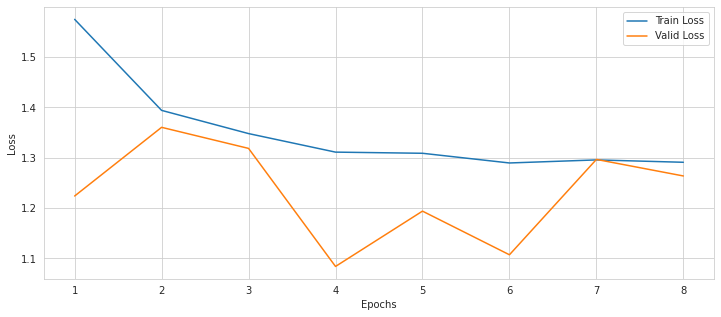

In [66]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

The plot above shows the total loss from each epoch for training and validation sets. 
The training set did flat out after the 4th epoch, perhaps 4 epochs would be enough. This makes sense since
this is a pretrained model, I only adjusted the output layers and trained them. the rest was already trained. 

The validation loss is fluctuating, which might indicate that the model overfits the data. The model might perform too well on the training set, thus it is difficult for the model to generalize on the validation set. 

Due to the diverse nature of the images (some images are in different color background, some wheat heads have completely different shapes)it might be possible that the model performs very well on some images, and poorly on some other images. I believe that with a large enough dataset this problem might be solved. But I do believe that the main issue is that the model slightly overfits. It might perform much better with a less powerful model, or even adding some dropout() layer to existing model can reduce the issue. 

In conclusion, the model shows satisfactory result. It detects most of the wheat objects in the test folder but it might have a slight overfitting issue. A very powerful model is not always the best model 

## 10. Kaggle Evaluation 

This competition is evaluated on the mean average precision (mAP) at different intersection over union IoU thresholds. The IoU of a set of predicted bounding boxes and ground truth bounding boxes is calculated as:

**IoU(A,B) = A∩B/AUB**

The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.75 with a step size of 0.05. In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.

At each threshold value t, a precision value is calculated based on the number of true positives TP, false negatives FN, and false positives FP resulting from comparing the predicted object to all ground truth objects:

**TP / (TP + FP + FN)**

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object.

The average precision of a single image is calculated as the mean of the above precision values at each IoU threshold:


**(1/thresholds) * ∑ TP / (TP + FP + FN)** <br>
The summation here is for each threshold value

Since all of the work was done on AWS, and the ground truth bounding boxes were not posted after the competition was over, I cannot produce this calculation on my own.

I was reading this post: https://www.kaggle.com/questions-and-answers/56689
But I am not sure it will work since my kernel gets disconnected every 30-60 minutes, and with Udacity's restrictions on EC2 I am not sure it is possible. 

In [ ]:
# for readme file on git:

# !pip freeze > requirements.txt